In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, variation
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from sequencing_tools.viz_tools import color_encoder
from sequencing_tools.stats_tools import normalize_count
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

In [2]:
ercc_df = pd.read_table('../data/ercc.tsv') \
    .drop('Len', axis=1) \
    .rename(columns = {'refA1':'NTCF1',
                     'refA2': 'NTCF2',
                     'refA3':'NTCF3'})\
    .pipe(lambda d: d[d.columns[~d.columns.str.contains('TPM')]]) \
    .assign(Type = 'ERCC') \
    .assign(Name = lambda d: d.ID) 
gene_df = pd.read_table('../data/all.tsv') \
    .filter(regex='ID|Name|Type|NT[CT][F][0-9]+')
abrf = pd.read_table('../data/countsData.tsv') \
    .filter(regex='ABRF|id') \
    .rename(columns={'id':'ID'}) \
    .groupby('ID', as_index=False)\
    .sum()
count_df = pd.concat([gene_df, ercc_df], axis=0) \
    .merge(abrf, how='inner', on ='ID')  \
    .pipe(lambda d: d[d.Type.str.contains('protein_coding|ERCC')])
count_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


,ID,NTCF1,NTCF2,NTCF3,NTTF1,NTTF2,NTTF3,Name,Type,ABRF-ILMN-L-A-1,...,ABRF-ILMN-RIBO-D-1,ABRF-ILMN-RIBO-D-2,ABRF-ILMN-RIBO-D-3,ABRF-ILMN-RIBO-D-4,ABRF-ILMN-V-A-1,ABRF-ILMN-V-A-2,ABRF-ILMN-V-A-3,ABRF-ILMN-V-B-1,ABRF-ILMN-V-B-2,ABRF-ILMN-V-B-3
19642,ENSG00000000003,1140,1103,1087,1201,1920,1089,TSPAN6,protein_coding,4098,...,480,465,487,375,2570,2970,2083,507,495,541
19643,ENSG00000000005,33,18,41,16,38,36,TNMD,protein_coding,128,...,5,11,15,5,83,106,80,26,30,22
19644,ENSG00000000419,2878,2669,2812,2843,4826,2627,DPM1,protein_coding,8395,...,1682,1743,1854,1365,5014,5632,4266,2685,2479,2763
19645,ENSG00000000457,992,885,931,882,1398,876,SCYL3,protein_coding,5632,...,996,980,1047,798,3407,3981,2925,2490,2352,2603
19646,ENSG00000000460,2257,1972,2417,2328,4030,2078,C1orf112,protein_coding,10168,...,1353,1390,1461,1056,6228,7576,5233,2727,2509,2818


In [3]:
df = normalize_count(count_df.filter(regex='ABRF|NTTF[0-9]+|NTCF[0-9]+'))\
    .pipe(lambda d: pd.concat([count_df.loc[:,['ID','Type','Name']],d], axis=1))\
    .pipe(lambda d: d[~d.Type.str.contains('rRNA')])\
    .drop(['Name','Type'], axis=1)\
    .rename(columns = lambda x: x.replace('.','-'))\
    .rename(columns = {'ID':'seq_id'}) \
    .filter(regex='-A-|NTT|NTC|seq_id')
df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:357: RuntimeWarning: divide by zero encountered in log
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:380: RuntimeWarning: divide by zero encountered in log
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


,seq_id,NTCF1,NTCF2,NTCF3,NTTF1,NTTF2,NTTF3,ABRF-ILMN-L-A-1,ABRF-ILMN-L-A-2,ABRF-ILMN-L-A-3,ABRF-ILMN-R-A-1,ABRF-ILMN-R-A-2,ABRF-ILMN-R-A-3,ABRF-ILMN-RIBO-A-1,ABRF-ILMN-RIBO-A-2,ABRF-ILMN-RIBO-A-3,ABRF-ILMN-RIBO-A-4,ABRF-ILMN-V-A-1,ABRF-ILMN-V-A-2,ABRF-ILMN-V-A-3
19642,ENSG00000000003,1448.816027,1547.561137,1354.985840,1556.670414,1522.374332,1545.441795,1469.535905,1434.803212,1484.834165,1265.875427,1216.178320,1161.291438,2663.628815,2657.913561,2828.839873,2939.459080,1446.337079,1412.057277,1373.358609
19643,ENSG00000000005,41.939411,25.254851,51.108022,20.738324,30.130325,51.088985,45.900585,52.885375,47.132433,50.092836,52.209675,45.986254,56.765860,54.456858,56.067097,52.895151,46.710497,50.396657,52.745410
19644,ENSG00000000419,3657.625022,3744.733160,3505.262356,3684.940873,3826.551315,3728.076763,3010.432876,2878.516460,2938.463410,2880.043396,2765.065355,2758.067166,7081.177150,7077.297023,8206.184137,9377.554546,2821.764247,2677.678984,2812.648981
19645,ENSG00000000457,1260.724122,1241.696833,1160.526050,1143.200088,1108.478810,1243.165300,2019.625725,1942.100422,1949.982522,2113.328344,1981.920225,2060.516631,2328.855795,2262.054094,2525.567851,2839.336116,1917.381490,1892.727279,1928.504048
19646,ENSG00000000460,2868.401555,2766.809214,3012.880198,3017.426082,3195.400290,2948.969742,3646.227693,3602.528738,3721.186849,3868.934908,3603.491318,3785.832251,7843.877423,7529.707842,8384.579444,9222.647319,3504.975614,3601.934656,3450.209123


In [4]:
mv_df = df \
    .pipe(pd.melt, id_vars = ['seq_id'], var_name = 'samplename', value_name = 'norm_count')\
    .assign(prep = lambda d: d.samplename.str.replace('[0-9]+$',''))\
    .groupby(['seq_id','prep'], as_index=False) \
    .agg({'norm_count':['mean','std','var',variation]}) 
new_col = mv_df.columns.get_level_values(0) + mv_df.columns.get_level_values(1)
mv_df.columns = new_col
mv_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:999: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


,seq_id,prep,norm_countmean,norm_countstd,norm_countvar,norm_countvariation
0,ENSG00000000003,ABRF-ILMN-L-A-,1463.057761,25.636865,657.248836,0.014307
1,ENSG00000000003,ABRF-ILMN-R-A-,1214.448395,52.313451,2736.697176,0.035171
2,ENSG00000000003,ABRF-ILMN-RIBO-A-,2772.460332,136.665646,18677.498788,0.042690
3,ENSG00000000003,ABRF-ILMN-V-A-,1410.584322,36.511525,1333.091452,0.021134
4,ENSG00000000003,NTCF,1450.454335,96.298102,9273.324357,0.054209


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


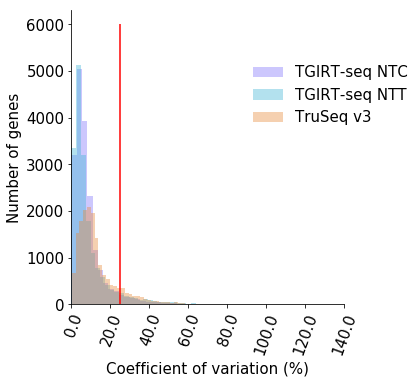

In [5]:
cutoff = 10
preps = ['TGIRT-seq NTC', 'TGIRT-seq NTT', 'TruSeq v3']
def prep_conversion(x):
    prep = ''
    if 'RIBO' in x:
        prep = preps[2]
    else:
        prep = 'TGIRT-seq ' + x
    return prep

p = sns.FacetGrid(data = mv_df\
                      .query('norm_countmean > %i' %cutoff)\
                      .pipe(lambda d: d[~d.prep.str.contains('-[RLV]-A')])\
                      .assign(cv = lambda d: 100 * d.norm_countvariation)\
                      .assign(prep = lambda d: d.prep.str.replace('F$',''))\
                      .assign(prep = lambda d: d.prep.map(prep_conversion))\
                      .sort_values('prep'), 
                  hue = 'prep', size=5,
                  hue_order = preps,
                 palette= ['#8174fc','#42b6d6','#e88b3a'])
p.map(sns.distplot, 'cv', kde=False, bins=50, hist_kws = {'alpha':0.4})
p.add_legend(title = '', bbox_to_anchor=(0.8,0.8), fontsize=15)
p.set_axis_labels('Coefficient of variation (%)', 
                  'Number of genes' )
ax = p.fig.axes[0]
ax.set_xlim(0,140)
#ax.set_ylim(0,0.1)
ax.vlines(x = 25, ymin=0,ymax = 6000, color='red')
xts = np.linspace(0,140, 8)
xt = ax.set_xticks(xts)
xt = ax.set_xticklabels(xts, rotation = 70, rotation_mode = 'anchor', ha = 'right')
p.savefig('../figures/cv_plot.eps')
p.savefig('../figures/cv_plot.png')

In [6]:
mv_df\
    .query('norm_countmean > %i' %cutoff)\
    .assign(reprod = lambda d: np.where(d.norm_countvariation <= 0.25,'<25%','>25%')) \
    .assign(gene_count = 1)\
    .groupby(['prep','reprod'], as_index=False)\
    .agg({'gene_count':'sum'}) \
    .assign(reprod_rate = lambda d: d.groupby(['prep']).gene_count.transform(lambda x: x/x.sum())) \
    .query('reprod == "<25%"')

,prep,reprod,gene_count,reprod_rate
0,ABRF-ILMN-L-A-,<25%,18315,0.999182
2,ABRF-ILMN-R-A-,<25%,18225,0.989575
4,ABRF-ILMN-RIBO-A-,<25%,14584,0.872092
6,ABRF-ILMN-V-A-,<25%,18545,0.995651
8,NTCF,<25%,17510,0.948692
10,NTTF,<25%,16984,0.920093


In [7]:
mv_df\
    .query('norm_countmean > %i' %cutoff)\
    .assign(reprod = lambda d: np.where(d.norm_countvariation <= 0.25,'<25%','>25%')) \
    .assign(gene_count = 1)\
    .groupby(['prep'], as_index=False)\
    .agg({'gene_count':'sum'}) \

,prep,gene_count
0,ABRF-ILMN-L-A-,18330
1,ABRF-ILMN-R-A-,18417
2,ABRF-ILMN-RIBO-A-,16723
3,ABRF-ILMN-V-A-,18626
4,NTCF,18457
5,NTTF,18459
